In [26]:
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

In [28]:
#TODO: graphing colors
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rcParams.update({'font.size': 22})

# Analyze Cost of Chemical Space (with MA)

## Step 1: Sample from cost of chemical space

Both randomly & uniformly across price ranges

In [28]:
# Read in data (in Orkney)
cost_df = pd.read_csv("U:\\Cost_of_chemical_space\\reaxys_database\\purchasable.csv")

print(cost_df.head())

           CAS  price                                               name  \
0  733030-83-6  109.3  2-(2-ethoxy-4-formylphenoxy)-N,N-dimethylpropa...   
1    7493-98-3   26.1      [(4-amino-3-bromophenyl)sulfanyl]formonitrile   
2  522598-07-8  104.8  5-[2-(4-methylphenyl)quinolin-4-yl]-4-(prop-2-...   
3  361150-39-2  128.3  methyl 3-butyl-4-oxo-2-sulfanyl-3,4-dihydroqui...   
4  721915-98-6  104.8  methyl 2-(1,4-dioxo-1,2,3,4-tetrahydrophthalaz...   

  supplier  reaxys_id  n_references  as_reagent  as_product  \
0  enamine         -1            -1          -1          -1   
1  enamine    2804471            12           1           6   
2  enamine         -1            -1          -1          -1   
3  enamine         -1            -1          -1          -1   
4  enamine         -1            -1          -1          -1   

                                        smiles  
0              CCOc1cc(C=O)ccc1OC(C)C(=O)N(C)C  
1                          N#CSc1ccc(N)c(Br)c1  
2  C=CCn1c(S)nnc1

In [5]:
## Random sample (50k)

random_df = cost_df.sample(n=50000)

random_df.to_csv("Data/Cost/random_cost_50k.csv")

In [29]:
## Uniform sampling over percentiles
labels = list(range(1,101,2))
cost_df["percentile"] = pd.qcut(cost_df.price, q=50, duplicates="drop", labels=labels)


In [32]:
#Randomly sample 1000 from each percentile
random_df = pd.concat([cost_df[cost_df["percentile"] == label].sample(1000) for label in labels])

print(random_df)

random_df.to_csv("Data/Cost/random_cost_percentiles_50k.csv")

                 CAS         price  \
282683    65100-04-1      2.224000   
28490     18595-14-7      2.600000   
254038     4515-21-3      1.862600   
255848      108-24-7      0.015346   
196580     2832-45-3      2.600000   
...              ...           ...   
163096   831249-87-7   7290.000000   
323199   660846-41-3  24019.200000   
95359            NaN  23790.000000   
191061  2092468-21-6   9180.000000   
328199     5205-34-5  24742.000000   

                                                     name    supplier  \
282683           3-Methacryloxypropylmethyldiethoxysilane  fluorochem   
28490                     methyl 4-amino-3-methylbenzoate     enamine   
254038          N-Benzyloxycarbonyl-DL-aspartic acid, 95%        alfa   
255848                             Acetic anhydride, 99+%        alfa   
196580                          sodium hexane-1-sulfonate     enamine   
...                                                   ...         ...   
163096  (2-chloro-4-nitrophenyl)

## Step 2: Analyze MA/cost correlation

Get MAs, merge with cost

MAs from AssemblyGo algorithm, timeout=300



In [8]:
#Get MA values
def get_MA(fp):
    """ Get AssemblyGo MA value

    Args:
        fp (str): filepath to a particular .txt AssemblyGo output file

    Returns:
        label (str): label of the compound which was analzyed
        MA (int): assemblyGo MA value
    """
    with open(fp) as f:
        lines = f.readlines()

    try:
        #molfile will be the last element in 0th line
        label = lines[0].split()[-1].split("/")[-1].split(".")[0]

        #MA will be last elemnt in -2nd line (will be an int)
        MA = int(lines[-2].split()[-1])
        
        return label, MA

    except:
        return None, None



In [9]:
#Get list of MA values, create a pandas dataframe of label/MA values
fp = "Data/AssemblyValues/CostRandom/"
result_files = [x for x in os.listdir(fp) if x.endswith(".txt")]

results = []
for f in tqdm(result_files):
    label, MA = get_MA(fp + f)
    results.append({"label": label, "MA": MA})
    

100%|██████████| 50000/50000 [00:07<00:00, 6660.65it/s]


In [17]:
results_df = pd.DataFrame(results)
results_df = results_df.dropna() #Drop failed runs (only 24 failed)
results_df = results_df.astype({"label":"int"})

print(results_df)

        label    MA
0       27869  12.0
1      238007   9.0
2       57356  11.0
3      153178   8.0
4      284840  11.0
...       ...   ...
49995  266604  11.0
49996  197645   7.0
49997  324345  27.0
49998  201847   8.0
49999  102448  12.0

[49976 rows x 2 columns]


In [19]:
## Merge random cost sample & MA database
random_cost_df = pd.read_csv("Data/AssemblyValues/CostRandom/random_cost_50k.csv")
random_cost_df = random_cost_df.astype({"Unnamed: 0": "int"})

#print(random_cost_df.head())

full_df = random_cost_df.merge(results_df, left_on="Unnamed: 0", right_on="label", how="outer")

print(full_df.head())


   Unnamed: 0           CAS     price  \
0      312645     2446-69-7   13.5664   
1      217713           NaN   75.9000   
2      144938     1759-55-3   58.8000   
3       81564  2095410-18-5  421.1000   
4      171801  1864299-18-2  169.3000   

                                                name supplier  reaxys_id  \
0                       4-Hexylphenol >= 98.0 % HPLC    sigma     387122   
1                3,6-dichloropyrazine-2-carbonitrile  enamine   14085485   
2             2,2-dimethylcyclopropane-1-carboxamide  enamine    2612300   
3  2-amino-4-chloro-5-fluorobenzene-1-thiol hydro...  enamine         -1   
4                      2-(bromomethyl)-6-phenyloxane  enamine         -1   

   n_references  as_reagent  as_product                 smiles     label   MA  
0           169         164          22      CCCCCCc1ccc(O)cc1  312645.0  8.0  
1            26          29          20      N#Cc1nc(Cl)cnc1Cl  217713.0  7.0  
2            28          75          11        CC1(C)CC1

Text(0.5, 1.0, 'Reaxys Price/MA Test: 50k Compounds')

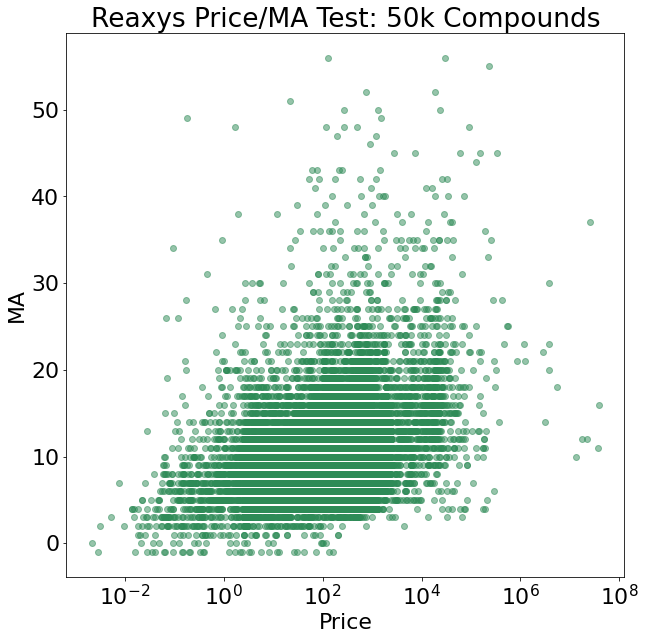

In [32]:
plt.figure(figsize=(10,10))

plt.scatter(full_df["price"], full_df["MA"], alpha=0.5, color="seagreen")

plt.xscale("log")

plt.xlabel("Price")
plt.ylabel("MA")
plt.title("Reaxys Price/MA Test: 50k Compounds")